# Moving Averages CINGULATE region

This corresponds to the visualization on the first HCP half of the t-SNE and clustering of the two models (first model being run on the first half, the second model being run on the second half of HCP)

# 1) Imports

In [2]:
import os
import glob
import sys
import json
import shutil

p = os.path.abspath('../')
if p not in sys.path:
    sys.path.append(p)

In [3]:
import moving_averages as ma
import colorado as cld
import dico_toolbox as dtx
from tqdm import tqdm

import pandas as pd
import numpy as np
from scipy.spatial import distance

import plotly.graph_objects as go
import pickle
import matplotlib.pyplot as plt

from soma import aims

import torch

from sklearn.cluster import KMeans, SpectralClustering, AffinityPropagation
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.manifold import TSNE

import matplotlib.cm as cm

from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from omegaconf import OmegaConf, DictConfig

In [4]:
# If true, saves meshes as files
save_mesh = False

# If true, saves buckets as files
save_bucket = False

# 2) Functions and datasets

In [5]:
def closest_distance(centroid, df):
    """Returns closest point to centroid of a given cluster
    /!\ central_point is part of the defined set of points
    Args:
        IN: centroid: tuple of coordinates of centroid
            df: pandas.DataFrame with index corresponding to subjects and as many columns as coordinates
        OUT: central_point: subject ID corresponding to closest point to the centroid
    """
    # df must have as many columns as dimensions to consider
    distances = {}
    # Get distances to centroid for each point
    for sub in list(df.index):
        pos = [df.loc[sub][k] for k in range(0, len(df.columns))]
        distances[sub] = distance.euclidean(pos, centroid)
    # Get closest point to centroid
    central_point = min(distances, key=distances.get)
    return central_point

In [6]:
def mscatter(x, y, ax=None, m=None, **kw):
    if not ax:
        ax = plt.gca()
    sc = ax.scatter(x, y, **kw)
    if (m is not None) and (len(m) == len(x)):
        paths = []
        for marker in m:
            if isinstance(marker, mmarkers.MarkerStyle):
                marker_obj = marker
            else:
                marker_obj = mmarkers.MarkerStyle(marker)
            path = marker_obj.get_path().transformed(
                marker_obj.get_transform())
            paths.append(path)
        sc.set_paths(paths)
    return sc

In [7]:
path = '/neurospin/dico/data/deep_folding/current/crops/CINGULATE/mask/sulcus_based/2mm/centered_combined/hcp/Rcrops/'

In [8]:
run_dir = '/host/volatile/jc225751/Runs/29_MIDL_2022_clean'

In [9]:
if torch.cuda.is_available():
    device = "cuda:0"
print(device)

cuda:0


In [10]:
# We load the embeddings
result_dir = f"{run_dir}/Output/t-0.1/n-004_o-4"
train_val_embeddings_file = f"{result_dir}/train_val_embeddings.pt"
embeddings = torch.load(train_val_embeddings_file)
print(embeddings.shape)

torch.Size([550, 4])


In [11]:
# We load the embeddings from the second half
result_dir2 = f"{run_dir}/Output/t-0.1/n-004_o-4_2nde_half"
train_val_embeddings_file2 = f"{result_dir2}/train_val_embeddings.pt"
embeddings2 = torch.load(train_val_embeddings_file2)
print(embeddings2.shape)

torch.Size([550, 4])


In [12]:
# We load the labels
with open(f"{result_dir}/train_val_filenames.json", 'r') as f:
    subject_labels = json.load(f)
print(subject_labels[0])    

129634


# 3) T-SNE and different clusterings

In [13]:
tsne = TSNE(n_components=2, perplexity=30, init='pca', random_state=50)
X_tsne = tsne.fit_transform(embeddings)

In [14]:
tsne2 = TSNE(n_components=2, perplexity=25, init='pca', random_state=50)
X_tsne2 = tsne2.fit_transform(embeddings2)

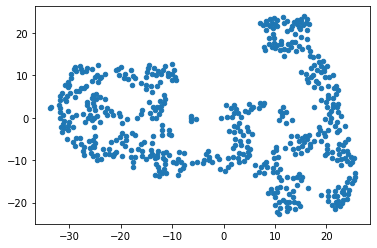

In [15]:
fig, ax = plt.subplots(1)
mscatter(X_tsne[:, 0], X_tsne[:, 1], s=20, ax=ax)
plt.show()


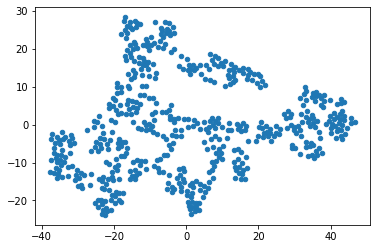

In [16]:
fig, ax = plt.subplots(1)
mscatter(X_tsne2[:, 0], X_tsne2[:, 1], s=20, ax=ax)
plt.show()

In [17]:
X_tsne.shape 

(550, 2)

In [18]:
X_tsne2.shape 

(550, 2)

In [19]:
def clustering_af(points_TSNE):
    af = AffinityPropagation().fit(points_TSNE)
    cluster_labels_af = af.labels_
    x_cluster_label_af = af.predict(points_TSNE)
    initial_centers = af.cluster_centers_indices_
    n_clusters_ = len(initial_centers)
    while n_clusters_ > 5:
        af = AffinityPropagation().fit(points_TSNE[af.cluster_centers_indices_])
        cluster_labels_af = af.labels_
        x_cluster_label_af = af.predict(points_TSNE)
        n_clusters_ = len(af.cluster_centers_indices_)
        print(n_clusters_)
    clusters_centers_af = af.cluster_centers_

    print(f"Average silhouette score: {metrics.silhouette_score(points_TSNE, x_cluster_label_af)}")

    return x_cluster_label_af, cluster_labels_af, clusters_centers_af


In [20]:
x_cluster_label_af, cluster_labels_af, clusters_centers_af = clustering_af(X_tsne)

4
Average silhouette score: 0.4238118529319763


In [21]:
x_cluster_label_af2, cluster_labels_af2, clusters_centers_af2 = clustering_af(X_tsne2)

4
Average silhouette score: 0.44882825016975403


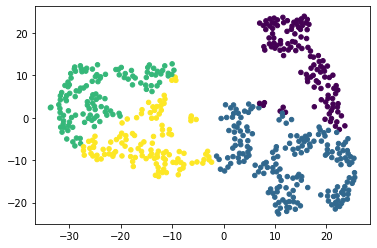

In [22]:
fig, ax = plt.subplots(1)
mscatter(X_tsne[:, 0], X_tsne[:, 1], c=x_cluster_label_af, s=20, ax=ax)
plt.show()

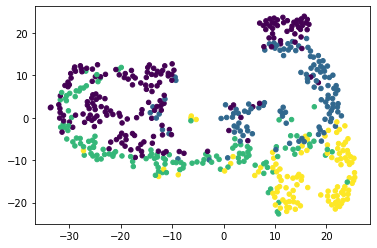

In [23]:
fig, ax = plt.subplots(1)
mscatter(X_tsne[:, 0], X_tsne[:, 1], c=x_cluster_label_af2, s=20, ax=ax)
plt.show()

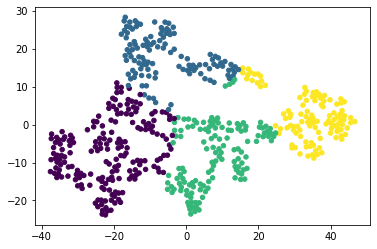

In [24]:
fig, ax = plt.subplots(1)
mscatter(X_tsne2[:, 0], X_tsne2[:, 1], c=x_cluster_label_af2, s=20, ax=ax)
plt.show()

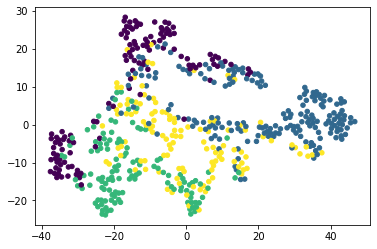

In [25]:
fig, ax = plt.subplots(1)
mscatter(X_tsne2[:, 0], X_tsne2[:, 1], c=x_cluster_label_af, s=20, ax=ax)
plt.show()

In [26]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(X_tsne)
cluster_labels_kmeans = kmeans.labels_
x_cluster_label_kmeans = kmeans.predict(X_tsne)
clusters_centroids_kmeans = kmeans.cluster_centers_
print(f"clusters centroids = {clusters_centroids_kmeans.shape}")
print(f"Average silhouette score: {metrics.silhouette_score(X_tsne, cluster_labels_kmeans)}")


clusters centroids = (10, 2)
Average silhouette score: 0.4572193920612335


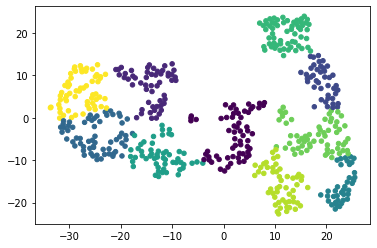

In [27]:
fig, ax = plt.subplots(1)
mscatter(X_tsne[:, 0], X_tsne[:, 1], c=x_cluster_label_kmeans, s=20, ax=ax)
plt.show()

In [28]:
dbscan = DBSCAN(eps=2).fit(X_tsne)
cluster_labels_dbscan = dbscan.labels_
x_cluster_label_dbscan = dbscan.fit_predict(X_tsne)
print(f"Average silhouette score: {metrics.silhouette_score(X_tsne, cluster_labels_dbscan)}")


Average silhouette score: 0.01872294768691063


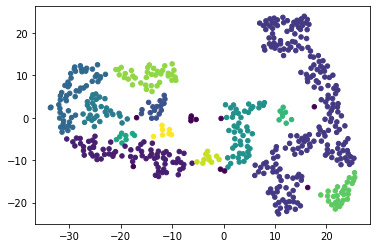

In [29]:
fig, ax = plt.subplots(1)
mscatter(X_tsne[:, 0], X_tsne[:, 1], c=x_cluster_label_dbscan, s=20, ax=ax)
plt.show()

# 4) MA with AffinityPropagation clustering

In [30]:
x_cluster_label_af.shape

(550,)

In [31]:
dstrb_sub = pd.DataFrame(X_tsne, index=subject_labels, columns=[0,1])
dstrb_sub['af_label'] = x_cluster_label_af

In [32]:
dstrb_sub.head()

0          1  af_label
129634 -25.234621  -6.989079         3
136833 -19.723698  -9.008698         3
206222  22.822351 -11.067300         1
138837  20.976093  -0.183199         0
987983  18.855858  10.753638         0

In [33]:
clusters_centroids = clusters_centers_af
print(f"cluster's centroids coordinates: \n {clusters_centroids}")

cluster's centroids coordinates: 
 [[ 18.855858   10.753638 ]
 [ 10.188089  -10.928673 ]
 [-27.188335    6.992881 ]
 [-14.090506   -7.6115336]]


In [34]:
dstrb_sub.loc[dstrb_sub.index[0]]

0          -25.234621
1           -6.989079
af_label     3.000000
Name: 129634, dtype: float64

In [35]:
central_af = []
for i in range(clusters_centroids.shape[0]):
    central_af.append(closest_distance(clusters_centroids[i], dstrb_sub.drop(['af_label'], axis=1)))
    print(f"Closest subject to centroid of cluster {i} is {central_af[i]}")

Closest subject to centroid of cluster 0 is 987983
Closest subject to centroid of cluster 1 is 137633
Closest subject to centroid of cluster 2 is 146836
Closest subject to centroid of cluster 3 is 105216


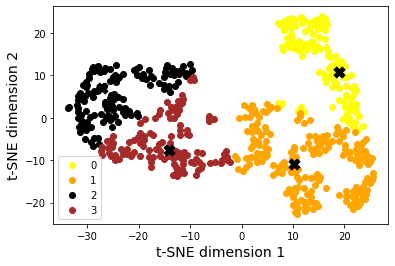

In [70]:
arr = np.array([np.array([dstrb_sub[k][i] for k in dstrb_sub.columns[0:2]]) for i in range(len(dstrb_sub))])

color_dict = {0: 'yellow', 1:'orange', 2:'black', 3:'brown'}
fig, ax = plt.subplots()

for g in np.unique([dstrb_sub.af_label]):
    ix = np.where(dstrb_sub.af_label == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    ax.scatter(x, y, c = color_dict[g], label = g)

for g in np.unique([dstrb_sub.af_label]):
    ax.scatter(clusters_centroids[g][0],
               clusters_centroids[g][1],
               color='black',
               marker='X',
               s=120)

plt.xlabel(f't-SNE dimension 1', fontsize=14)
plt.ylabel(f't-SNE dimension 2', fontsize=14)
plt.legend()
plt.show()

In [42]:
betavae = pd.read_csv('label_bvae.csv')

In [43]:
betavae.head()

Unnamed: 0          1          2  cluster_lab
0      131924 -19.186666   5.052786            3
1      692964  17.274990  12.390187            2
2      159946 -23.090307   0.775272            3
3      122822  13.033621  31.161682            0
4      352132   8.874580 -42.764572            1

In [46]:
betavae = betavae.rename(columns={"Unnamed: 0":"subjects"})

In [49]:
betavae.subjects = betavae.subjects.astype('str')

In [37]:
dstrb_sub.head()

0          1  af_label
129634 -25.234621  -6.989079         3
136833 -19.723698  -9.008698         3
206222  22.822351 -11.067300         1
138837  20.976093  -0.183199         0
987983  18.855858  10.753638         0

In [ ]:
m2 = pd.merge(dstrb_sub, betavae, left_on=dstrb_sub.index, right_on=betavae.subjects)

In [53]:
m2 = m2.rename(columns={"cluster_lab": "betavae_lab"})

In [54]:
m2 = m2.rename(columns={"af_label": "simclr_lab"})

In [55]:
m2.head()

key_0          0          1  simclr_lab subjects          1          2  \
0  129634 -25.234621  -6.989079           3   129634  13.234862 -39.168453   
1  136833 -19.723698  -9.008698           3   136833  14.744742 -13.902143   
2  206222  22.822351 -11.067300           1   206222  -9.973412  -6.130984   
3  138837  20.976093  -0.183199           0   138837 -23.123827   5.394363   
4  987983  18.855858  10.753638           0   987983  -1.782911  34.792870   

   betavae_lab  
0            1  
1            2  
2            3  
3            3  
4            0

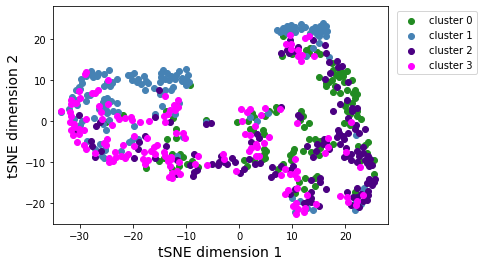

In [63]:
arr = np.array([np.array([m2[k][i] for k in m2.columns[1:3]]) for i in range(len(m2))])

color_dict = {0:'forestgreen',1: 'steelblue', 2:'indigo', 3:'magenta'}
fig, ax = plt.subplots()

for g in np.unique([m2.betavae_lab]):
    ix = np.where(m2.betavae_lab == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    ax.scatter(x, y, c = color_dict[g], label = f"cluster {g}")

plt.xlabel(f'tSNE dimension 1', fontsize=14)
plt.ylabel(f'tSNE dimension 2', fontsize=14)
plt.legend(bbox_to_anchor=(1.28,1))
plt.xlim(-35,28)
plt.ylim(-25,28)
plt.show()

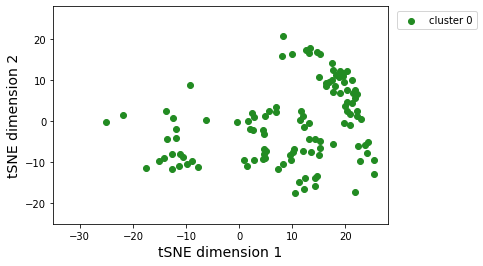

In [64]:
arr = np.array([np.array([m2[k][i] for k in m2.columns[1:3]]) for i in range(len(m2))])

color_dict = {0:'forestgreen',1: 'steelblue', 2:'indigo', 3:'magenta'}
fig, ax = plt.subplots()

for g in np.unique([m2.betavae_lab]):
    if g == 0:
        ix = np.where(m2.betavae_lab == g)
        x = [arr[ix][k][0] for k in range(len(ix[0]))]
        y = [arr[ix][k][1] for k in range(len(ix[0]))]
        ax.scatter(x, y, c = color_dict[g], label = f"cluster {g}")

plt.xlabel(f'tSNE dimension 1', fontsize=14)
plt.ylabel(f'tSNE dimension 2', fontsize=14)
plt.legend(bbox_to_anchor=(1.28,1))
plt.xlim(-35,28)
plt.ylim(-25,28)
plt.show()

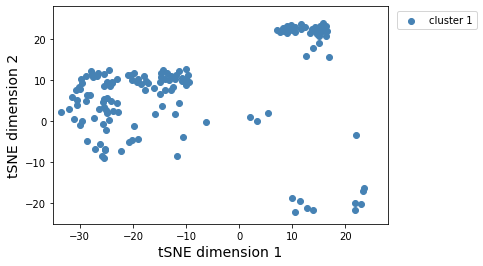

In [65]:
arr = np.array([np.array([m2[k][i] for k in m2.columns[1:3]]) for i in range(len(m2))])

color_dict = {0:'forestgreen',1: 'steelblue', 2:'indigo', 3:'magenta'}
fig, ax = plt.subplots()

for g in np.unique([m2.betavae_lab]):
    if g == 1:
        ix = np.where(m2.betavae_lab == g)
        x = [arr[ix][k][0] for k in range(len(ix[0]))]
        y = [arr[ix][k][1] for k in range(len(ix[0]))]
        ax.scatter(x, y, c = color_dict[g], label = f"cluster {g}")

plt.xlabel(f'tSNE dimension 1', fontsize=14)
plt.ylabel(f'tSNE dimension 2', fontsize=14)
plt.legend(bbox_to_anchor=(1.28,1))
plt.xlim(-35,28)
plt.ylim(-25,28)
plt.show()

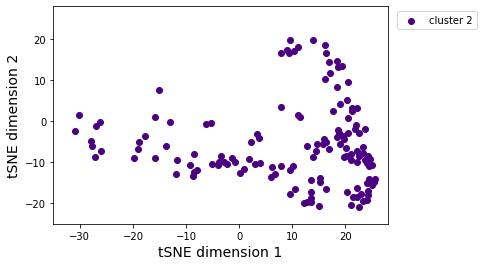

In [66]:
arr = np.array([np.array([m2[k][i] for k in m2.columns[1:3]]) for i in range(len(m2))])

color_dict = {0:'forestgreen',1: 'steelblue', 2:'indigo', 3:'magenta'}
fig, ax = plt.subplots()

for g in np.unique([m2.betavae_lab]):
    if g == 2:
        ix = np.where(m2.betavae_lab == g)
        x = [arr[ix][k][0] for k in range(len(ix[0]))]
        y = [arr[ix][k][1] for k in range(len(ix[0]))]
        ax.scatter(x, y, c = color_dict[g], label = f"cluster {g}")

plt.xlabel(f'tSNE dimension 1', fontsize=14)
plt.ylabel(f'tSNE dimension 2', fontsize=14)
plt.legend(bbox_to_anchor=(1.28,1))
plt.xlim(-35,28)
plt.ylim(-25,28)
plt.show()

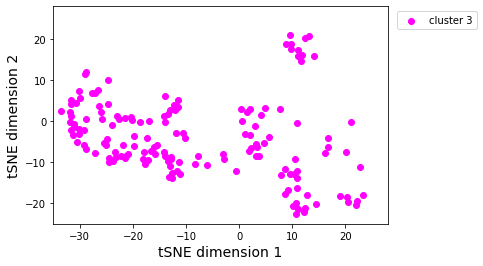

In [67]:
arr = np.array([np.array([m2[k][i] for k in m2.columns[1:3]]) for i in range(len(m2))])

color_dict = {0:'forestgreen',1: 'steelblue', 2:'indigo', 3:'magenta'}
fig, ax = plt.subplots()

for g in np.unique([m2.betavae_lab]):
    if g == 3:
        ix = np.where(m2.betavae_lab == g)
        x = [arr[ix][k][0] for k in range(len(ix[0]))]
        y = [arr[ix][k][1] for k in range(len(ix[0]))]
        ax.scatter(x, y, c = color_dict[g], label = f"cluster {g}")

plt.xlabel(f'tSNE dimension 1', fontsize=14)
plt.ylabel(f'tSNE dimension 2', fontsize=14)
plt.legend(bbox_to_anchor=(1.28,1))
plt.xlim(-35,28)
plt.ylim(-25,28)
plt.show()

In [39]:
simclr_labels = dstrb_sub[['af_label']]

In [40]:
simclr_labels.to_csv('simclr_labels.csv')

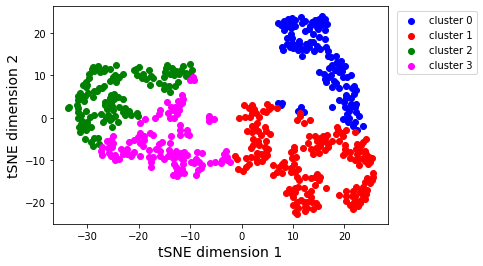

In [36]:
arr = np.array([np.array([dstrb_sub[k][i] for k in dstrb_sub.columns[0:2]]) for i in range(len(dstrb_sub))])

color_dict = {0: 'blue', 1:'red', 2:'green', 3:'magenta'}
fig, ax = plt.subplots()

for g in np.unique([dstrb_sub.af_label]):
    ix = np.where(dstrb_sub.af_label == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    ax.scatter(x, y, c = color_dict[g], label = f"cluster {g}")

plt.xlabel(f'tSNE dimension 1', fontsize=14)
plt.ylabel(f'tSNE dimension 2', fontsize=14)
plt.legend(bbox_to_anchor=(1.28,1))
plt.show()

In [37]:
print(len(dstrb_sub))

550


In [38]:
clusters = []
for lab in np.unique([dstrb_sub.af_label]):
    cluster_df = dstrb_sub[dstrb_sub.af_label==lab]
    clusters.append(cluster_df)
for lab in np.unique([dstrb_sub.af_label]):
    assert(len(np.unique(list(clusters[lab].af_label)))==1)

### Creation of buckets dictionnary

In [39]:
bucket_path = '/neurospin/dico/data/deep_folding/current/crops/CINGULATE/mask/sulcus_based/2mm/centered_combined/hcp/Rbuckets/'
suffix_path = '_normalized.bck'
buckets = {}
for sub in tqdm(list(subject_labels)):
    bucket = aims.read(os.path.join(bucket_path, str(sub) + suffix_path))
    bucket = dtx.convert.bucket_aims_to_ndarray(bucket[0])
    buckets[sub] = bucket

100%|██████████| 550/550 [00:26<00:00, 20.48it/s]


In [40]:
clusters[0].index

Index(['138837', '987983', '182032', '151021', '151930', '667056', '192439',
       '185442', '115825', '206323',
       ...
       '194645', '154330', '151829', '176441', '199958', '723141', '123420',
       '349244', '163331', '433839'],
      dtype='object', length=119)

In [41]:
subjects = []
for lab in range(len(clusters)):
    subject = clusters[lab].index
    subjects.append(subject)

In [42]:
buckets_c = []
for lab in range(len(subjects)):
    bucket_c = {k: v for k,v in buckets.items() if k in list(subjects[lab])}
    buckets_c.append(bucket_c)

In [43]:
cld.draw(list(buckets_c[0].values())[0])

#### Alignement of the subjects to respective central subject

In [44]:
aligned_buckets = []
aligned_rot = []
aligned_transl = []

for lab in range(len(subjects)):
    print(lab)
    buck, rot, trans = ma.align_buckets_by_ICP_batch(buckets_c[lab], central_af[lab])
    aligned_buckets.append(buck)
    aligned_rot.append(rot)
    aligned_transl.append(trans)

>>> INFO moving_averages.transform - using 45 cores out of 48


0


Aligning buckets to 987983: 100%|██████████| 119/119 [00:01<00:00, 114.64it/s]
>>> INFO moving_averages.transform - using 45 cores out of 48


1


Aligning buckets to 137633: 100%|██████████| 189/189 [00:01<00:00, 117.01it/s]
>>> INFO moving_averages.transform - using 45 cores out of 48


2


Aligning buckets to 146836: 100%|██████████| 124/124 [00:01<00:00, 121.52it/s]
>>> INFO moving_averages.transform - using 45 cores out of 48


3


Aligning buckets to 105216: 100%|██████████| 118/118 [00:01<00:00, 88.52it/s]


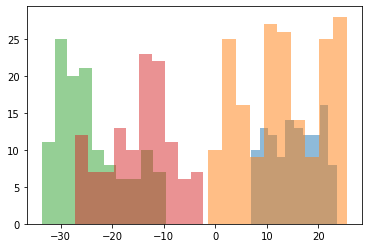

In [45]:
for lab in range(len(subjects)):
    plt.hist(clusters[lab][0], alpha=0.5)
plt.show()

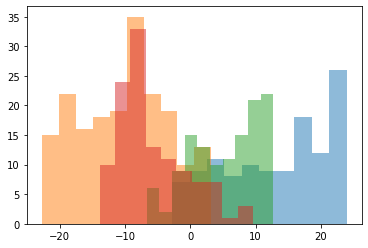

In [46]:
for lab in range(len(subjects)):
    plt.hist(clusters[lab][1], alpha=0.5)
plt.show()

In [47]:
def subj_count_extreme_coords(isodf, axis, min_coord, max_coord, num_coord=10):
    coord_values = np.linspace(min_coord, max_coord, num_coord)
    step = (coord_values[1] - coord_values[0])
    midpoint_min = coord_values[0] + step/2
    midpoint_max = coord_values[num_coord-1] - step/2
    coord_under = [elt for elt in isodf[axis] if elt<midpoint_min]
    coord_over = [elt for elt in isodf[axis] if elt>midpoint_max]
    num_subj_under = len(coord_under)
    num_subj_over = len(coord_over)
    return num_subj_under, num_subj_over

def get_MA_coords(isodf, axis, num_subj_threshold, num_coord=10):
    min_subj_coord = min(isodf[axis])
    max_subj_coord = max(isodf[axis])
    step = (max_subj_coord - min_subj_coord)/num_coord
    num_subj_under, num_subj_over = subj_count_extreme_coords(isodf, axis, min_subj_coord, max_subj_coord)
    while ((num_subj_under<num_subj_threshold)|(num_subj_over<num_subj_threshold)):
        step = (max_subj_coord - min_subj_coord)/num_coord
        if num_subj_under<num_subj_threshold:
            min_subj_coord = min_subj_coord + step
        if num_subj_over<num_subj_threshold:
            max_subj_coord = max_subj_coord - step
        num_subj_under, num_subj_over = subj_count_extreme_coords(isodf, axis, min_subj_coord, max_subj_coord)
    return np.linspace(min_subj_coord, max_subj_coord, num_coord)

In [48]:
clusters[0].head()

0          1  af_label
138837  20.976093  -0.183199         0
987983  18.855858  10.753638         0
182032  16.245895  20.737886         0
151021  17.420820   9.973657         0
151930  16.893147  14.431960         0

In [49]:
clusters_centroids

array([[ 18.855858 ,  10.753638 ],
       [ 10.188089 , -10.928673 ],
       [-27.188335 ,   6.992881 ],
       [-14.090506 ,  -7.6115336]], dtype=float32)

## Average on the first axis (AF)

In [50]:
FWHM = [100., 100., 100., 100.]
SPAM_vols = [[], []]
shift = [[], []]
for ax in [0, 1]:
    for i in range(len(subjects)):
        vol_1, shift_1 = ma.moving_averages_tools.calc_one_MA_volume(
            buckets_dict=aligned_buckets[i], 
            distance_df=clusters[i],
            axis_n=ax,
            center=clusters_centroids[i][ax],
            FWHM=FWHM[i])
        SPAM_vols_1 = dict({clusters_centroids[i][ax]:vol_1})
        SPAM_vols[ax].append(SPAM_vols_1)
        shift[ax].append(shift_1)


In [51]:
SPAM_meshes = [[], []]
# thresholds = [0.6, 0.65, 0.57, 0.62]
threshold = '88%'

for ax in [0, 1]:
    for i in range(len(subjects)):
        SPAM_mesh_1 = {}

        for k, volume in tqdm(list(SPAM_vols[ax][i].items())[:]):
            SPAM_mesh_1[k]=dtx.convert.volume_to_mesh(
                            vol=volume,
                            gblur_sigma=0.3,
                            threshold=threshold,
                            deciReductionRate=0,
                            smoothRate=0.1)
        SPAM_meshes[ax].append(SPAM_mesh_1)



100%|██████████| 1/1 [00:00<00:00, 22.85it/s]


In [52]:
fig = cld.draw(list(SPAM_vols[0][0].values())[0], th_min=0.2)
cld.draw(list(SPAM_meshes[0][0].values())[0], fig=fig)

In [53]:
SPAM_shift_meshes = [[], []]
for ax in [0, 1]:
    for i in range(len(subjects)):
        SPAM_mesh_1 = {}
        for dist, mesh in SPAM_meshes[ax][i].items():
            SPAM_mesh_1[str(dist)] = \
                dtx.mesh.shift_aims_mesh_along_axis(
                    mesh, 0., axis=0, scale=1)
        SPAM_shift_meshes[ax].append(SPAM_mesh_1)

In [54]:
if save_mesh:
    for mesh_file in glob.glob("*.mesh*"):
        print(mesh_file)
        os.remove(mesh_file)
    for ax in [0, 1]:
        for i in range(len(subjects)):
            SPAM_shift_mesh = SPAM_shift_meshes[ax][i]
            for _, mesh in SPAM_shift_mesh.items():
                mesh_file = f"AF_cluster_ax{ax}_{i}.mesh"
                print(mesh_file)
                aims.write(mesh, mesh_file)
                del mesh

## Find typical examples (AF)

In [55]:
clusters[0].head()

0          1  af_label
138837  20.976093  -0.183199         0
987983  18.855858  10.753638         0
182032  16.245895  20.737886         0
151021  17.420820   9.973657         0
151930  16.893147  14.431960         0

In [56]:
clusters[0].nsmallest(2,[0])

0          1  af_label
168240  7.006992   3.381572         0
133625  7.020972  22.283823         0

In [57]:
def compute_distance(df_in, centroid):
    """Computes distance from centroid"""
    df_out = df_in
    df_out['distance'] = (df_out[0]-centroid[0])**2 + (df_out[1]-centroid[1])**2
    return df_out

In [58]:
clusters[0] = compute_distance(clusters[0], clusters_centroids[0])

In [59]:
neighbours = []
for i in range(len(subjects)):
    clusters[i] = compute_distance(clusters[i], clusters_centroids[i])
    neighbours.append(list(clusters[i].nsmallest(4,'distance').index))
print(neighbours)

[['987983', '580650', '111009', '162026'], ['137633', '209228', '767464', '529549'], ['146836', '129129', '182840', '761957'], ['105216', '361941', '140117', '268850']]


In [60]:
buckets['987983']

array([[ 7., 27.,  1.],
       [ 6., 28.,  1.],
       [11., 27.,  2.],
       ...,
       [10.,  6., 35.],
       [11.,  6., 35.],
       [10.,  7., 35.]])

In [61]:
if save_bucket:
    for idx, lab in enumerate(neighbours):
        for sub in lab:
            sub_bucket = dtx.convert.bucket_numpy_to_bucketMap_aims(buckets[sub])
            aims.write(sub_bucket, f"{idx}_{sub}.bck")

# 5) MA with Kmeans

In [62]:
dstrb_sub['kmeans_label'] = x_cluster_label_kmeans

In [63]:
dstrb_sub.head()

0          1  af_label  kmeans_label
129634 -25.234621  -6.989079         3             3
136833 -19.723698  -9.008698         3             3
206222  22.822351 -11.067300         1             4
138837  20.976093  -0.183199         0             7
987983  18.855858  10.753638         0             2

In [64]:
clusters_centroids_kmeans

array([[  1.932714 ,  -4.0915556],
       [-14.140398 ,   7.4624553],
       [ 19.195377 ,   8.438675 ],
       [-24.68092  ,  -4.352781 ],
       [ 23.025106 , -15.978607 ],
       [-12.144989 ,  -8.933054 ],
       [ 12.112993 ,  19.846977 ],
       [ 18.010944 ,  -4.2441235],
       [ 11.172321 , -15.83111  ],
       [-27.81254  ,   6.0992756]], dtype=float32)

In [65]:
n_clusters_kmeans = clusters_centroids_kmeans.shape[0]

In [66]:
central_kmeans = []
for i in range(n_clusters_kmeans):
    central_kmeans.append(closest_distance(clusters_centroids_kmeans[i], dstrb_sub.drop(['af_label', 'kmeans_label'], axis=1)))
    print(f"Closest subject to centroid of cluster {i} is {central_kmeans[i]}")

Closest subject to centroid of cluster 0 is 159946
Closest subject to centroid of cluster 1 is 136631
Closest subject to centroid of cluster 2 is 206323
Closest subject to centroid of cluster 3 is 583858
Closest subject to centroid of cluster 4 is 152831
Closest subject to centroid of cluster 5 is 894067
Closest subject to centroid of cluster 6 is 891667
Closest subject to centroid of cluster 7 is 962058
Closest subject to centroid of cluster 8 is 826353
Closest subject to centroid of cluster 9 is 761957


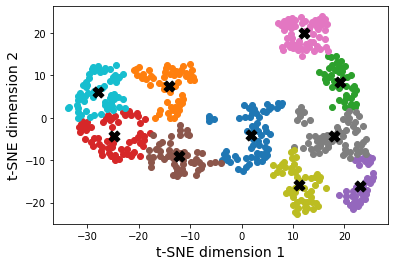

In [67]:
arr = np.array([np.array([dstrb_sub[k][i] for k in dstrb_sub.columns[0:2]]) for i in range(len(dstrb_sub))])

# color_dict = {0: 'blue', 1:'red', 2:'green', 3:'magenta'}
fig, ax = plt.subplots()

for g in np.unique([dstrb_sub.kmeans_label]):
    ix = np.where(dstrb_sub.kmeans_label == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    ax.scatter(x, y, label = g)

for g in np.unique([dstrb_sub.kmeans_label]):
    ax.scatter(clusters_centroids_kmeans[g][0],
               clusters_centroids_kmeans[g][1],
               color='black',
               marker='X',
               s=120)

plt.xlabel(f't-SNE dimension 1', fontsize=14)
plt.ylabel(f't-SNE dimension 2', fontsize=14)
plt.show()

In [68]:
clusters_kmeans = []
for lab in np.unique([dstrb_sub.kmeans_label]):
    cluster_df = dstrb_sub[dstrb_sub.kmeans_label==lab]
    clusters_kmeans.append(cluster_df)
for lab in np.unique([dstrb_sub.af_label]):
    assert(len(np.unique(list(clusters_kmeans[lab].kmeans_label)))==1)

In [69]:
clusters_kmeans[0].index 

Index(['573249', '127731', '123824', '137431', '102816', '210415', '132118',
       '208428', '896879', '395756', '205220', '185846', '133928', '106521',
       '360030', '519950', '136732', '144933', '557857', '397154', '173233',
       '793465', '387959', '445543', '366042', '599671', '168038', '143325',
       '952863', '339847', '170631', '664757', '130114', '300618', '185947',
       '827052', '113316', '179245', '169141', '163836', '140319', '221218',
       '208327', '205725', '151223', '751550', '200917', '159946', '424939',
       '687163', '616645', '134728', '810439', '144731', '168240', '200513',
       '110007', '131924', '679770', '150019', '663755', '618952', '541943'],
      dtype='object')

In [70]:
subjects_kmeans = []
for lab in range(n_clusters_kmeans):
    subject = clusters_kmeans[lab].index
    subjects_kmeans.append(subject)

In [71]:
buckets_kmeans_c = []
for lab in range(n_clusters_kmeans):
    bucket_c = {k: v for k,v in buckets.items() if k in list(subjects_kmeans[lab])}
    buckets_kmeans_c.append(bucket_c)
print(len(buckets_kmeans_c))

10


In [72]:
aligned_buckets_kmeans = []
aligned_rot_kmeans = []
aligned_transl_kmeans = []

for lab in range(n_clusters_kmeans):
    print(lab)
    buck, rot, trans = ma.align_buckets_by_ICP_batch(buckets_kmeans_c[lab], central_kmeans[lab])
    aligned_buckets_kmeans.append(buck)
    aligned_rot_kmeans.append(rot)
    aligned_transl_kmeans.append(trans)

>>> INFO moving_averages.transform - using 45 cores out of 48


0


Aligning buckets to 159946: 100%|██████████| 63/63 [00:00<00:00, 78.70it/s]
>>> INFO moving_averages.transform - using 45 cores out of 48


1


Aligning buckets to 136631: 100%|██████████| 54/54 [00:00<00:00, 103.38it/s]
>>> INFO moving_averages.transform - using 45 cores out of 48


2


Aligning buckets to 206323: 100%|██████████| 42/42 [00:00<00:00, 116.89it/s]
>>> INFO moving_averages.transform - using 45 cores out of 48


3


Aligning buckets to 583858: 100%|██████████| 63/63 [00:00<00:00, 90.45it/s] 
>>> INFO moving_averages.transform - using 45 cores out of 48


4


Aligning buckets to 152831: 100%|██████████| 38/38 [00:00<00:00, 101.88it/s]
>>> INFO moving_averages.transform - using 45 cores out of 48


5


Aligning buckets to 894067: 100%|██████████| 54/54 [00:00<00:00, 106.36it/s]
>>> INFO moving_averages.transform - using 45 cores out of 48


6


Aligning buckets to 891667: 100%|██████████| 60/60 [00:00<00:00, 107.99it/s]
>>> INFO moving_averages.transform - using 45 cores out of 48


7


Aligning buckets to 962058: 100%|██████████| 62/62 [00:00<00:00, 99.89it/s]
>>> INFO moving_averages.transform - using 45 cores out of 48


8


Aligning buckets to 826353: 100%|██████████| 53/53 [00:00<00:00, 97.57it/s]
>>> INFO moving_averages.transform - using 45 cores out of 48


9


Aligning buckets to 761957: 100%|██████████| 61/61 [00:00<00:00, 102.43it/s]


In [73]:
FWHM = [100.]*10
SPAM_vols_kmeans = [[], []]
shift_kmeans = [[], []]
for ax in [0, 1]:
    for i in range(n_clusters_kmeans):
        vol_1, shift_1 = ma.moving_averages_tools.calc_one_MA_volume(
            buckets_dict=aligned_buckets_kmeans[i], 
            distance_df=clusters_kmeans[i],
            axis_n=ax,
            center=clusters_centroids_kmeans[i][ax],
            FWHM=FWHM[i])
        SPAM_vols_1 = dict({clusters_centroids_kmeans[i][ax]:vol_1})
        SPAM_vols_kmeans[ax].append(SPAM_vols_1)
        shift_kmeans[ax].append(shift_1)


In [74]:
SPAM_meshes_kmeans = [[], []]
# thresholds = [0.6, 0.65, 0.57, 0.62]
threshold = '92%'

for ax in [0, 1]:
    for i in range(n_clusters_kmeans):
        SPAM_mesh_1 = {}

        for k, volume in tqdm(list(SPAM_vols_kmeans[ax][i].items())[:]):
            SPAM_mesh_1[k]=dtx.convert.volume_to_mesh(
                            vol=volume,
                            gblur_sigma=0.3,
                            threshold=threshold,
                            deciReductionRate=0,
                            smoothRate=0.1)
        SPAM_meshes_kmeans[ax].append(SPAM_mesh_1)


100%|██████████| 1/1 [00:00<00:00, 30.77it/s]


In [75]:
fig = cld.draw(list(SPAM_vols_kmeans[0][0].values())[0], th_min=0.2)
cld.draw(list(SPAM_meshes_kmeans[0][0].values())[0], fig=fig)

In [76]:
SPAM_shift_meshes_kmeans = [[], []]
for ax in [0, 1]:
    for i in range(n_clusters_kmeans):
        SPAM_mesh_1 = {}
        for dist, mesh in SPAM_meshes_kmeans[ax][i].items():
            SPAM_mesh_1[str(dist)] = \
                dtx.mesh.shift_aims_mesh_along_axis(
                    mesh, 0., axis=0, scale=1)
        SPAM_shift_meshes_kmeans[ax].append(SPAM_mesh_1)

In [77]:
if save_mesh:
    for ax in [0, 1]:
        for i in range(n_clusters_kmeans):
            SPAM_shift_mesh = SPAM_shift_meshes_kmeans[ax][i]
            for _, mesh in SPAM_shift_mesh.items():
                mesh_file = f"kmeans_cluster_ax{ax}_{i}.mesh"
                print(mesh_file)
                aims.write(mesh, mesh_file)
                del mesh